<a href="https://www.mbd.rwth-aachen.de/">
    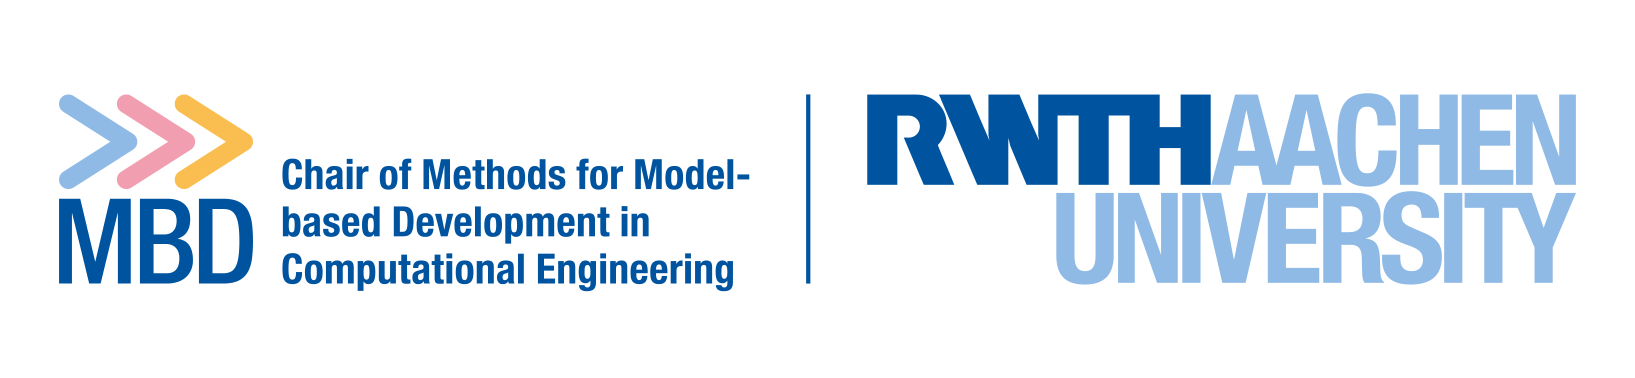
</a>
<a href="https://www.cpbl.rwth-aachen.de/">
    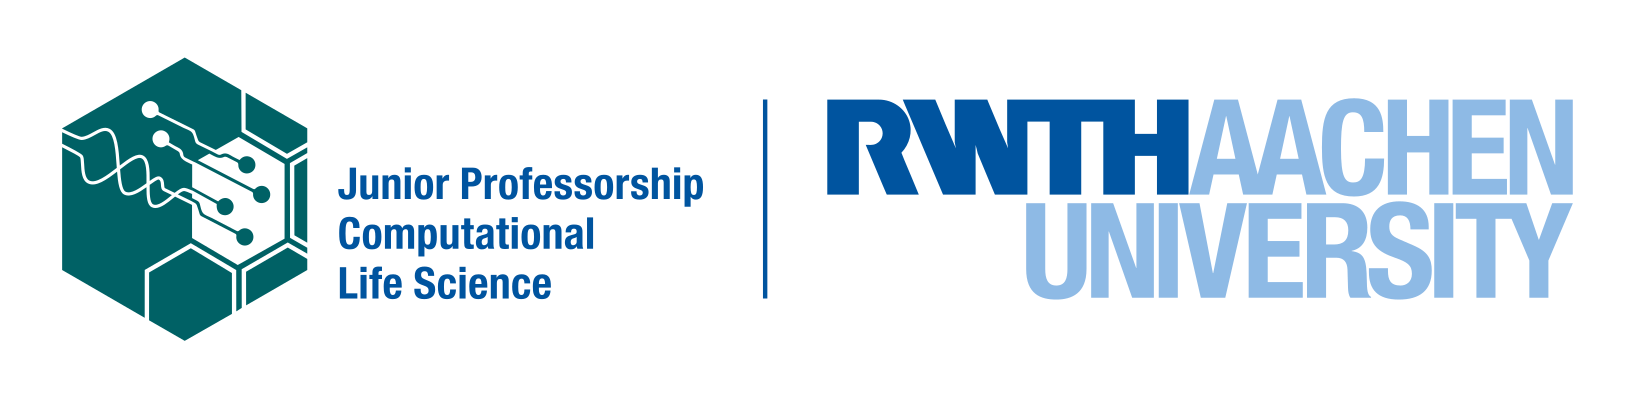
</a>

# Societal Challenges Datathon

Name: Risa Niranjan Chaudhari

Student number (Matrikelnummer): 485510

### Loading Dataset

In [172]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Define helper function to load .xpt dataset
def load_dataset(file_path):
    df = pd.read_sas(file_path, format='xport')
    print(f"Loaded {file_path.split('/')[-1]} with shape {df.shape}")
    return df

# load all .XPT files in data/raw directory
data_dir = 'data/raw'
datasets = {}
for file in os.listdir(data_dir):
    if file.endswith('.XPT'):
        dataset_name = file.split('.')[0]
        datasets[dataset_name] = load_dataset(os.path.join(data_dir, file))


Loaded raw\acculturation.XPT with shape (11372, 5)
Loaded raw\alcohol_use.XPT with shape (6337, 9)
Loaded raw\audiometry.XPT with shape (11744, 14)
Loaded raw\blood_pressure_cholesterol.XPT with shape (8501, 6)
Loaded raw\current_health_status.XPT with shape (6615, 2)
Loaded raw\dermatology.XPT with shape (4305, 4)
Loaded raw\diabetes.XPT with shape (11744, 9)
Loaded raw\diet_behavior_nutrition.XPT with shape (11933, 27)
Loaded raw\early_childhood.XPT with shape (3432, 7)
Loaded raw\functioning.XPT with shape (10942, 32)
Loaded raw\health_insurance.XPT with shape (11933, 11)
Loaded raw\hepatitis.XPT with shape (10696, 2)
Loaded raw\hospital_utilization_access_to_care.XPT with shape (11933, 6)
Loaded raw\housing_characteristics.XPT with shape (11933, 2)
Loaded raw\immunization.XPT with shape (11565, 6)
Loaded raw\income.XPT with shape (11933, 5)
Loaded raw\kidney_condition_urology.XPT with shape (7809, 9)
Loaded raw\medical_conditions.XPT with shape (11744, 35)
Loaded raw\mental_health_

#### variable mapping

In [173]:
var_map = pd.read_csv("data/extra/variables.csv")

# renmame columns based on variable mapping
rename_dict = dict(zip(var_map['Variable Name'], var_map['Renamed_variables']))
for original, new in rename_dict.items():
    print(f"{original} -> {new}")

# apply renaming to all datasets
for name, df in datasets.items():
    datasets[name] = df.rename(columns=rename_dict)


AUQ054 -> HearingStatus_NoAid
AUQ101 -> DifficultyHearing_WithBackgroundNoise
AUQ144 -> LastHearingTest_Specialist
AUQ410A -> reason_hearing_loss_A
AUQ410B -> reason_hearing_loss_B
AUQ410C -> reason_hearing_loss_C
AUQ410D -> reason_hearing_loss_D
AUQ410E -> reason_hearing_loss_E
AUQ410F -> reason_hearing_loss_F
AUQ410G -> reason_hearing_loss_G
AUQ410H -> reason_hearing_loss_H
AUQ410I -> reason_hearing_loss_I
AUQ410J -> reason_hearing_loss_J
SEQN -> sequence_no
DID040 -> Age_DiabetesDiagnosis
DID060 -> InsulinDuration
DIQ010 -> EverTold_Diabetes
DIQ050 -> CurrentlyTaking_Insulin
DIQ060U -> nan
DIQ070 -> CurrentlyTaking_DiabeticPills
DIQ160 -> EverTold_Prediabetes
DIQ180 -> BloodSugarTest_Last3Years
RXQ033 -> PrescriptionMedication_Used_Last30Days
RXQ050 -> PrescriptionMeds_Count_Last30Days
RXQ510 -> EverTold_TakeAspirin
RXQ515 -> Following_AspirinAdvice
RXQ520 -> TakingAspirinOnOwn
DUQ230 -> DaysUsed_Marijuana_Last30Days
DUQ250 -> EverUsed_Cocaine
DUQ290 -> EverUsed_Heroin
DUQ330 -> Eve

In [174]:
print(datasets.keys())

dict_keys(['acculturation', 'alcohol_use', 'audiometry', 'blood_pressure_cholesterol', 'current_health_status', 'dermatology', 'diabetes', 'diet_behavior_nutrition', 'early_childhood', 'functioning', 'health_insurance', 'hepatitis', 'hospital_utilization_access_to_care', 'housing_characteristics', 'immunization', 'income', 'kidney_condition_urology', 'medical_conditions', 'mental_health_depression_screener', 'occupation', 'oral_health', 'pesticide_use', 'physical_activity', 'physical_activity_youth', 'prescription_medications', 'preventive_aspirin_use', 'sleep_disorders', 'smoking_cigarette_use', 'smoking_household_smokers', 'smoking_recent_tobacco_use', 'weight_history'])


In [175]:
print(datasets['diabetes'].columns)

Index([                  'sequence_no',             'EverTold_Diabetes',
               'Age_DiabetesDiagnosis',          'EverTold_Prediabetes',
           'BloodSugarTest_Last3Years',       'CurrentlyTaking_Insulin',
                     'InsulinDuration',                             nan,
       'CurrentlyTaking_DiabeticPills'],
      dtype='object')


### Filtering  Columns

In [176]:
# drop empty columns and columns with all NaN values
for name, df in datasets.items():
    datasets[name] = df.dropna(axis=1, how='all')
    datasets[name] = datasets[name].loc[:,datasets[name].columns.notna()]

#### Cleaning algo

In [177]:
import pandas as pd

def clean_nhanes_module(df, binary_cols=None, ordinal_cols=None, numeric_cols=None):

    df = df.loc[:, ~df.columns.duplicated()]
    
    binary_cols = binary_cols or []
    ordinal_cols = ordinal_cols or []
    numeric_cols = numeric_cols or []

    # -------------------------
    # Binary variables (1=Yes, 2=No)
    # -------------------------
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].replace({
                1: 1,
                2: 2,
                7: pd.NA,
                9: pd.NA,
                77: pd.NA,
                99: pd.NA
            })

    # -------------------------
    # Ordinal categorical variables
    # -------------------------
    for col in ordinal_cols:
        if col in df.columns:
            df[col] = df[col].replace({
                7: pd.NA,
                9: pd.NA,
                77: pd.NA,
                99: pd.NA,
                7777: pd.NA,
                9999: pd.NA,
                666666: pd.NA,
                777777: pd.NA, # Refused
                999999: pd.NA  # Don't know
            })

    # -------------------------
    # Numeric variables
    # -------------------------
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].replace({
                7: pd.NA,
                9: pd.NA,
                77: pd.NA,
                99: pd.NA,
                777: pd.NA,
                999: pd.NA,
                7777: pd.NA,
                9999: pd.NA,
                666666: pd.NA
            })
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

#### Diabetes Dataset

In [178]:
datasets['diabetes'] = clean_nhanes_module(
    datasets['diabetes'],

    binary_cols=[
        'EverTold_Diabetes',
        'CurrentlyTaking_Insulin',
        'CurrentlyTaking_DiabeticPills',
        'EverTold_Prediabetes',
        'BloodSugarTest_Last3Years'
    ],

    ordinal_cols=[],

    numeric_cols=[
        'Age_DiabetesDiagnosis',
        'InsulinDuration'
    ]
)

In [179]:
# Drop all the rows which have diabetes diagonsis as NA
print(f"Before dropping NA in 'EverTold_Diabetes': {datasets['diabetes'].shape}")
datasets['diabetes'] = datasets['diabetes'].dropna(subset=['EverTold_Diabetes'])
print(f"After dropping NA in 'EverTold_Diabetes': {datasets['diabetes'].shape}")


# Number of people diagnoses with diabetes , not diagnosed with diabetes and borderline diabetes
print(datasets['diabetes']['EverTold_Diabetes'].value_counts())

# Drop borderline diabetes cases (code 3) to focus on clear cases of diabetes vs no diabetes
datasets['diabetes'] = datasets['diabetes'][datasets['diabetes']['EverTold_Diabetes'] != 3.0]
print(f"After dropping borderline diabetes cases: {datasets['diabetes'].shape}")

Before dropping NA in 'EverTold_Diabetes': (11744, 8)
After dropping NA in 'EverTold_Diabetes': (11736, 8)
EverTold_Diabetes
2.0    10371
1.0     1081
3.0      284
Name: count, dtype: int64
After dropping borderline diabetes cases: (11452, 8)


#### Blood Pressure and Cholesterol Dataset

In [180]:
datasets['blood_pressure_cholesterol'] = clean_nhanes_module(
    datasets['blood_pressure_cholesterol'],

    binary_cols=[
        'EverTold_Hypertension',
        'CurrentlyTaking_BloodPressureMedication',
        'EverTold_HighCholesterol',
        'CurrentlyTaking_CholesterolMedication',
        'ConfirmedHypertension_Visits'
    ],

    ordinal_cols=[],

    numeric_cols=[]
)

#### Alcohol Use Dataset

In [181]:
datasets['alcohol_use'] = clean_nhanes_module(
    datasets['alcohol_use'],

    binary_cols=[
        'EverHad_Alcohol',
        'DailyHeavyDrinkingHistory'
    ],

    ordinal_cols=[
        'AlcoholConsumptionFrequency_12Months',
        'MoreThanSpecificNumberOfDrinksFrequency',
        'HeavyDrinkingWithinTwoHoursFrequency_12Months',
        'MoreThan8DrinksPerDay_12Months'
    ],

    numeric_cols=[
        'AverageDrinksPerDrinkingDay_12Months',
        'OccasionsWithHeavyDrinking_30Days'
    ]
)

#### Weight History

In [182]:
datasets['weight_history'] = clean_nhanes_module(
    datasets['weight_history'],

    binary_cols=[
        'TriedToLoseWeight_Past12Months'
    ],

    ordinal_cols=[
        # none in this module
    ],

    numeric_cols=[
        'CurrentHeight',
        'CurrentWeight',
        'WeightOneYearAgo'
    ]
)

#### Physical Activity Dataset

In [183]:


datasets['physical_activity'] = clean_nhanes_module(
    datasets['physical_activity'],
    binary_cols=[

    ],

    ordinal_cols=[

    ],

    numeric_cols=[
        'SittingTime_TypicalDay',
        'Duration_ModerateActivity_PerSession',
        'Duration_VigorousActivity_PerSession',
        'Days_PhysicallyActive_AtLeast60Min_Last7Days',
        'ScreenTime_TypicalDay_SchoolYear',
        'Frequency_ModerateActivity',
        'Frequency_VigorousActivity'
    ]
)


#### Income

In [184]:
datasets['income'] = clean_nhanes_module(
    datasets['income'],

    binary_cols=[
        'MoreThan5000_InSavings',
        'FamilyPovertyLevelIndex_Categories',
        'FamilyPovertyLevelIndex_Ratio'
    ],

    ordinal_cols=[
        'TotalSavings_CashAssets',
    ],

    numeric_cols=[
    ]
)


#### Health insurance dataset

In [185]:
datasets['health_insurance'] = clean_nhanes_module(
    datasets['health_insurance'],

    binary_cols=[
        'Has_HealthInsurance',    
        'HealthInsurance_Medicare',
        'HealthInsurance_MediGap',
        'HealthInsurance_Medicaid',
        'HealthInsurance_CHIP',
        'HealthInsurance_Military',
        'HealthInsurance_StateSponsoredHealthPlan',
        'HealthInsurance_OtherGovernmentInsurance',
        'NoHealthInsurance_Past12Months'
    ],

    ordinal_cols=[
        'HealthInsurance_Private',
    ],

    numeric_cols=[

    ]
)


#### Diet Behavior Nutrition Dataset

In [186]:
datasets['diet_behavior_nutrition'] = clean_nhanes_module(
    datasets['diet_behavior_nutrition'],

    binary_cols=[
        'EverBreastfed',
        'MealsDeliveredHome_Past12Months',
        'AttendedCommunityMeals_Past12Months',
        'CurrentlyAttendingSchool',
        'SchoolServesLunches',
        'SchoolServesBreakfastsAtConstantCostsDaily',
        'MealPlanningResponsibility',
        'MealPreparationSharing',
        'FoodShoppingResponsibility',
        'FoodShoppingSharing'
    ],

    ordinal_cols=[
        'LunchCostStatus',
        'BreakfastCostStatus',
        'SummerProgramMealCostsStatus'
    ],

    numeric_cols=[
        'AgeStoppedBreastfeeding',
        'AgeFirstFedFormula',
        'AgeStoppedDrinkingFormula',
        'AgeFirstFedOtherThanBreastMilk_inDays',
        'AgeFirstFedMilk',
        'NumberWeeklyCompleteSchoolLunches',
        'NumberWeeklyCompleteSchoolBreakfasts'
    ]
)


#### Smoking Cigarette Use Dataset

In [187]:
datasets['smoking_cigarette_use'] = clean_nhanes_module(
    datasets['smoking_cigarette_use'],

    binary_cols=[
        'SmokedAtLeast100CigarettesInLife',
        'SmokingTypeMenthol'
    ],

    ordinal_cols=[
        'CurrentCigaretteSmoking'
    ],

    numeric_cols=[
        'FirstCigaretteAge',
        'CigarettesSmokedDays_30Days',
        'CigarettesPerDayOnSmokingDays_30Days',
        'TotalCigarettesSmoked',
        'NumberOfPeopleSmokingInHome',
        'NumberOfPeopleSmokingInsideHome'
    ]
)


#### Kidney Disease Dataset

In [188]:
datasets['kidney_condition_urology'] = clean_nhanes_module(
    datasets['kidney_condition_urology'],

    binary_cols=[
        'EverTold_KidneyFailure',
        'DialysisReceived_12Months',
        'LeakageWithActivity_12Months',
        'LeakageWithUrgency_12Months'
    ],

    ordinal_cols=[
        'UrineLeakageFrequency',
        'UrineLeakageAmount',
        'ImpactOfLeakageOnLife_12Months',
        'NightUrinationFrequency_30Days'
    ],

    numeric_cols=[
    ]
)


#### Medical Conditions Dataset

In [189]:
datasets['medical_conditions'] = clean_nhanes_module(
    datasets['medical_conditions'],

    binary_cols=[
        'EverTold_Asthma',
        'StillHave_Asthma',
        'EverTold_Arthritis',
        'EverTold_CongestiveHeartFailure',
        'EverTold_CoronaryHeartDisease',
        'EverTold_Angina',
        'EverTold_HeartAttack',
        'EverTold_Stroke',
        'EverTold_LiverCondition',
        'EverTold_ThyroidProblem',
        'EverTold_COPD',
        'StillHave_LiverCondition',
        'StillHave_ThyroidProblem',
        'EverTold_Cancer',
        'EverTold_Gallstones',
        'EverHad_GallbladderSurgery'
    ],

    ordinal_cols=[
        'TypeOfArthritis',
        'TypeOfCancer_1st',
        'TypeOfCancer_2nd',
        'TypeOfCancer_3rd'
    ],

    numeric_cols=[
    ]
)


### Merging Datasets

In [190]:
# Left join all datasets on SEQN to create a master dataset 
print("Merging datasets...")

master_df = datasets['diabetes']
for name, df in datasets.items():
    if name != 'diabetes':  # Skip the diabetes dataset since it's our starting point
        master_df = master_df.merge(df, on='sequence_no', how='left')

# drop currently taking insulin and currently taking diabetic pills since they are highly correlated with diabetes diagnosis and may cause data leakage
master_df.drop(columns=['CurrentlyTaking_Insulin', 'CurrentlyTaking_DiabeticPills','Age_DiabetesDiagnosis'], inplace=True)
print(f"Shape after dropping insulin and diabetic pills columns: {master_df.shape}")
print(f"Master dataset shape after merging: {master_df.shape}")

Merging datasets...
Shape after dropping insulin and diabetic pills columns: (11452, 245)
Master dataset shape after merging: (11452, 245)


In [191]:
leakage_cols = [
    'sequence_no',
    "PrescriptionMeds_Count_Last30Days",
    "PrescriptionMedication_Used_Last30Days",
    "BloodSugarTest_Last3Years",
    "EverTold_Prediabetes",
    "InsulinDuration",
    "CurrentlyTaking_Insulin",
    "CurrentlyTaking_DiabeticPills",
    "CurrentlyTaking_CholesterolMedication",
    "EverTold_TakeAspirin",
]


# drop leakage columns
master_df.drop(columns=[col for col in leakage_cols if col in master_df.columns], inplace=True)
print("Removed leakage features.")
print("New feature count:", master_df.shape[1])

Removed leakage features.
New feature count: 237


In [192]:
def convert_time_to_minutes(col):

    def safe_convert(val):
        if pd.isna(val):
            return pd.NA
        
        val = str(val)
        val = val.replace("b'", "").replace("'", "")
        
        if ":" not in val:
            return pd.NA
        
        try:
            hours, minutes = val.split(":")
            return int(hours) * 60 + int(minutes)
        except:
            return pd.NA

    return col.apply(safe_convert)


# Convert time columns to minutes
time_cols = [
    'WeekdaySleepTime',
    'WeekdayWakeTime',
    'WeekendSleepTime',
    'WeekendWakeTime'
]

# print unique values in time columns before conversion to see the format


for col in time_cols:
    if col in master_df.columns:
        master_df[col] = convert_time_to_minutes(master_df[col])
        print(f"Converted column '{col}' to minutes.")



Converted column 'WeekdaySleepTime' to minutes.
Converted column 'WeekdayWakeTime' to minutes.
Converted column 'WeekendSleepTime' to minutes.
Converted column 'WeekendWakeTime' to minutes.


In [193]:
# Convert to csv and save in data/processed directory 

os.makedirs('data/processed', exist_ok=True)
output_path = 'data/processed/master_dataset.csv'
master_df.to_csv(output_path, index=False)
print(f"Master dataset saved to {output_path}")

Master dataset saved to data/processed/master_dataset.csv


### Processing 

In [194]:
## Load master dataset and check data types
master_df = pd.read_csv('data/processed/master_dataset.csv')
# shape
print(f"Master dataset shape: {master_df.shape}")

Master dataset shape: (11452, 237)


In [195]:
# Remove duplicate columns (keep first occurrence)
master_df = master_df.loc[:, ~master_df.columns.duplicated()]

print("Shape after removing duplicates:", master_df.shape)

Shape after removing duplicates: (11452, 237)


In [196]:
# Find columns with string data types and  convert them to numeric if possible
for col in master_df.columns:
    if master_df[col].dtype == 'object':
        try:
            master_df[col] = pd.to_numeric(master_df[col], errors='coerce')
            print(f"Converted column '{col}' to numeric.")
        except Exception as e:
            # drop the column if it cannot be converted to numeric
            print(f"Could not convert column '{col}' to numeric: {e}")
            

### Handling Missing Values

**Strategy:**
Missing data is a common issue in healthcare datasets. This section addresses missing values through a multi-step approach:

1. **High Missingness Removal**: Columns with >99% missing values are dropped as they provide negligible information
2. **Binary Variable Imputation**: For binary variables (2 unique values), missing values are filled with the mode (most frequent value)
3. **Numeric Variable Imputation**: For continuous/numeric features, missing values are filled with the median (robust to outliers)
4. **Categorical Variable Imputation**: For ordinal/categorical features, missing values are filled with the mode

This approach preserves data distribution while handling missing values appropriately based on variable type. The goal is to retain as much information as possible while avoiding bias from missing data patterns.

In [197]:
# Summary table
missing_summary = master_df.isna().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary.to_frame(name='Missing (%)')
missing_summary


,Missing (%)
HealthInsurance_OtherGovernmentInsurance,100.000000
MoreThan3Cancers,99.982536
TypeOfLiverCondition_2,99.973804
ProductsUsed_5,99.930143
FirstTypeOfMilkFed_4,99.860286
...,...
HearingStatus_NoAid,0.000000
TelehealthAppointment_Past12Months,0.000000
HasUsualPlace_ForCare,0.000000
AnemiaTreatment_Last3Months,0.000000


In [198]:
# remove data that has more than 99% missing values
cols_to_drop = missing_summary[missing_summary['Missing (%)'] > 99].index.tolist()
master_df.drop(columns=cols_to_drop, inplace=True)

print(cols_to_drop)
print(f"Shape after dropping columns with >99% missing values: {master_df.shape}")

['HealthInsurance_OtherGovernmentInsurance', 'MoreThan3Cancers', 'TypeOfLiverCondition_2', 'ProductsUsed_5', 'FirstTypeOfMilkFed_4', 'TypeOfLiverCondition_5', 'FirstTypeOfMilkFed_5', 'TypeOfCancer_3rd', 'FirstCigaretteAge', 'DifficultyWalkingWithoutAssistance_Level', 'ProductsUsed_2', 'NumberOfDaysSmokedPipe_5Days', 'LanguageSpokenAtHome_2', 'reason_hearing_loss_E', 'ProductsUsed_4', 'TypeOfLiverCondition_3', 'ProductsUsed_7', 'NumberOfDaysSmokedWaterPipeHookah_5Days', 'ProductsUsed_8', 'TypeOfLiverCondition_4', 'reason_hearing_loss_J', 'FirstTypeOfMilkFed_3', 'TypeOfLiverCondition_6', 'reason_hearing_loss_D', 'ProductsUsed_6', 'FirstTypeOfMilkFed_6', 'reason_hearing_loss_C', 'HealthInsurance_CHIP', 'Weight_2']
Shape after dropping columns with >99% missing values: (11452, 208)


In [199]:
#  Impute binary
# identify binary columns (those with only 2 unique non-NA values)
binary_cols = [col for col in master_df.columns if master_df[col].dropna().nunique() == 2]
for col in binary_cols:
    master_df[col] = master_df[col].fillna(master_df[col].mode()[0])

#  Impute numeric
numeric_cols = master_df.select_dtypes(include=['float64','int64']).columns
for col in numeric_cols:
    master_df[col] = master_df[col].fillna(master_df[col].median())

ordinary_cols = master_df.select_dtypes(include=['object']).columns
for col in ordinary_cols:
    master_df[col] = master_df[col].fillna(master_df[col].mode()[0])

In [200]:
# print missing values after imputation
missing_summary_after = master_df.isna().mean().sort_values(ascending=False) * 100
missing_summary_after = missing_summary_after.to_frame(name='Missing (%) After Imputation')
missing_summary_after

,Missing (%) After Imputation
EverTold_Diabetes,0.0
LanguageSpokenAtHome_1,0.0
LanguageSpokenAtHome_3,0.0
RatioEnglishSpanishAtHome,0.0
EverHad_Alcohol,0.0
...,...
UsedAnyTobaccoProduct_5Days,0.0
CurrentHeight,0.0
CurrentWeight,0.0
WeightOneYearAgo,0.0


Add BMI column 

BMI=weight/height*2


In [201]:
# create a colummn for BMI using weight and height
master_df['BMI'] = (master_df['CurrentWeight'] * 0.453592) / ((master_df['CurrentHeight'] * 0.0254) ** 2)
print(f"Shape after imputation: {master_df.shape}")

Shape after imputation: (11452, 209)


### Exploratory Data Analysis ( EDA )

#### Univariate Analysis

**Purpose:**
Examines individual variables in isolation to understand their distributions, central tendencies, and spread.

**Analyses Performed:**
1. **Target Variable Distribution**: Visualizes the class imbalance between diabetes and non-diabetes cases using count plots
2. **Numeric Variables**: Histograms with KDE (Kernel Density Estimation) overlays to show distribution shapes, skewness, and potential outliers for features like height, weight, and physical activity metrics
3. **Categorical Variables**: Bar plots showing frequency distributions of binary health conditions (hypertension, high cholesterol, smoking status, etc.)

**Key Insights:**
- Identifies class imbalance in the target variable (important for model selection)
- Reveals distribution shapes (normal, skewed, bimodal) which inform feature engineering decisions
- Highlights potential data quality issues (outliers, unexpected values)

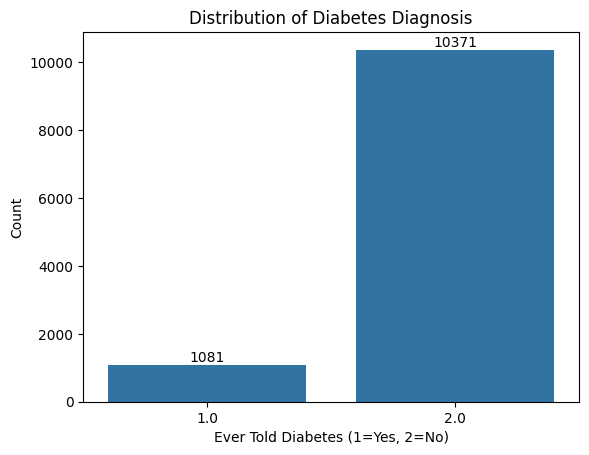

In [202]:
# plot target variable distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='EverTold_Diabetes', data=master_df)
plt.title('Distribution of Diabetes Diagnosis')
plt.xlabel('Ever Told Diabetes (1=Yes, 2=No)')
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')
plt.ylabel('Count')
plt.show()

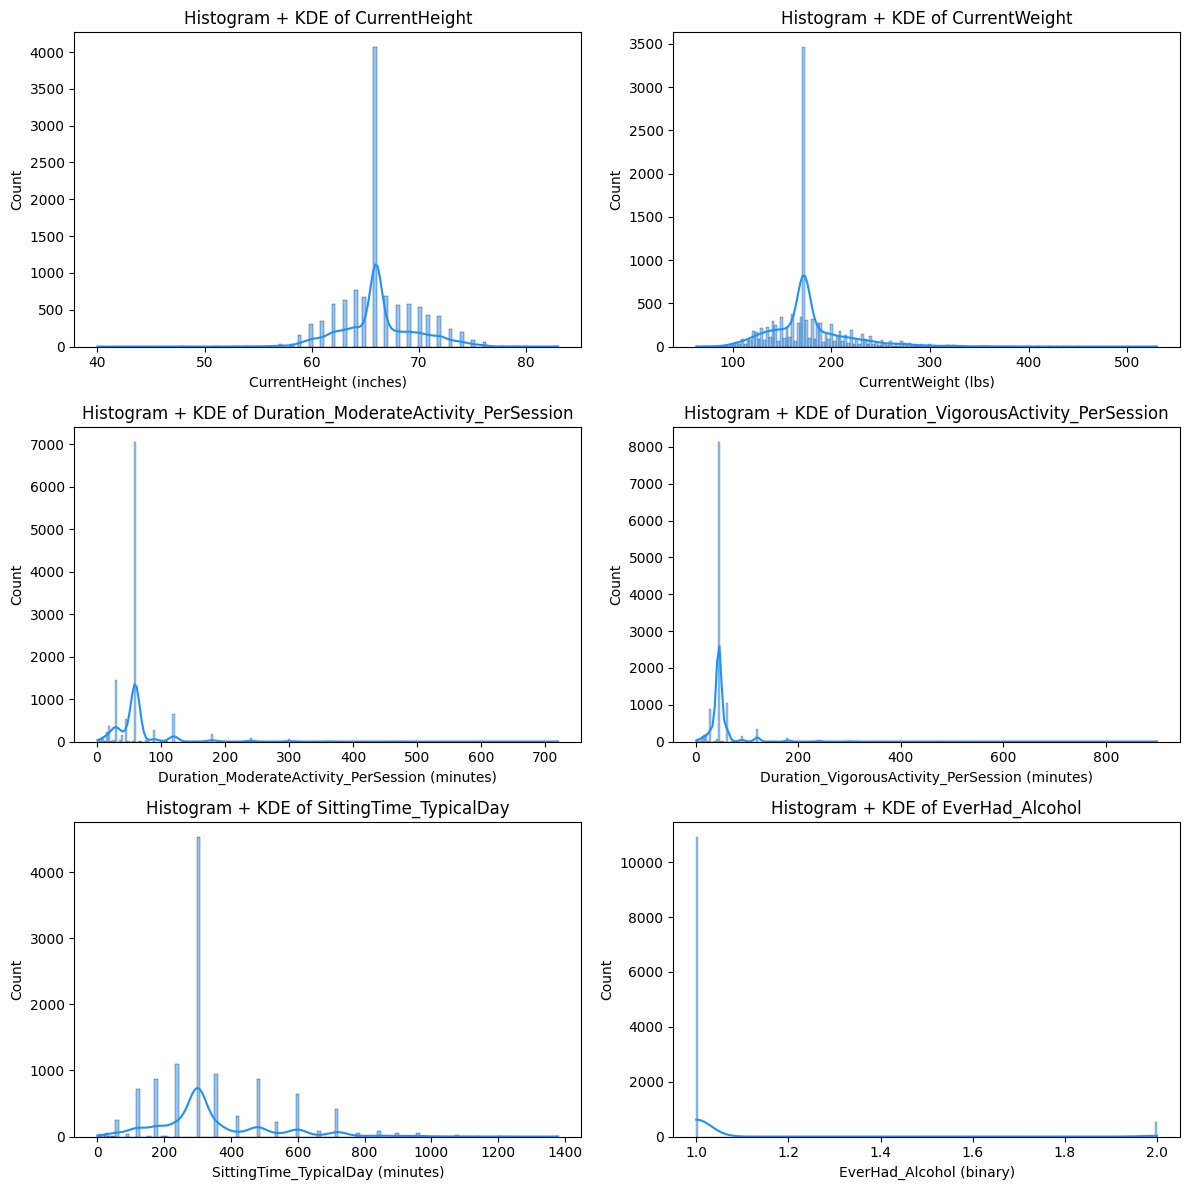

In [203]:
import math

# univaraiate analysis of numeric variables
# Numeric variables
numeric_cols = ['CurrentHeight', 'CurrentWeight', 
                'Duration_ModerateActivity_PerSession', 
                'Duration_VigorousActivity_PerSession', 'SittingTime_TypicalDay','EverHad_Alcohol']

# Define units for each column (fill according to dataset documentation or logical guess)
# Example units dictionary
units = {
    'CurrentHeight': 'inches',
    'CurrentWeight': 'lbs',
    'Duration_ModerateActivity_PerSession': 'minutes',
    'Duration_VigorousActivity_PerSession': 'minutes',
    'SittingTime_TypicalDay': 'minutes', 
    'EverHad_Alcohol': 'binary'
}

# numeric variables
numeric_cols = list(units.keys())

# Determine number of rows needed for 2-column grid
n_cols = 2
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # flatten for easy indexing



for i, col in enumerate(numeric_cols):
    sns.histplot(master_df[col].dropna(), kde=True, color='dodgerblue', ax=axes[i])
    axes[i].set_title(f'Histogram + KDE of {col}')
    axes[i].set_xlabel(f'{col} ({units[col]})')  # add unit here

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

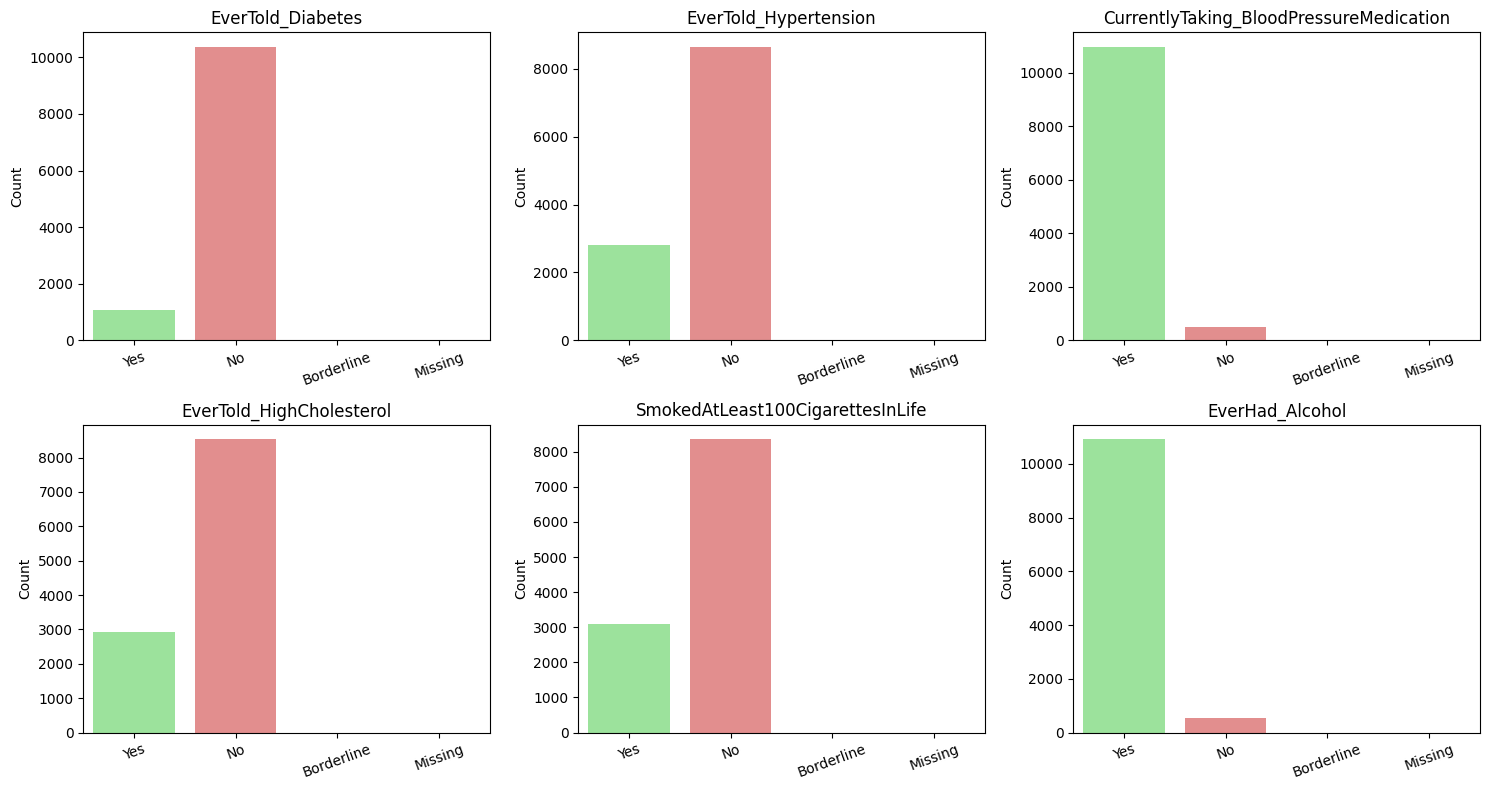

In [204]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical variables (adjust list as needed)
categorical_cols = [
    'EverTold_Diabetes', 'EverTold_Hypertension',
    'CurrentlyTaking_BloodPressureMedication', 'EverTold_HighCholesterol',
    'SmokedAtLeast100CigarettesInLife', 'EverHad_Alcohol',
]

# Keep only columns that exist in master_df
existing_cols = [col for col in categorical_cols if col in master_df.columns]

# plotting grid
n_cols = 3
n_rows = math.ceil(len(existing_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Map numeric codes to labels (1 -> Yes, 2 -> No, 3 -> Borderline)
value_map = {
    1: "Yes",
    2: "No",
    3: "Borderline"
}

# Color mapping for labels
color_map = {
    "Yes": "lightgreen",
    "No": "lightcoral",
    "Borderline": "lightblue",
    "Missing": "lightgray",
    # Optional: if you expect "Other(...)" labels you can add a color for them
}

def map_label(x):
    # Convert pd.NA / NaN -> Missing
    if pd.isna(x):
        return "Missing"
    # Try to cast to int for float-coded categories (e.g., 1.0)
    try:
        xi = int(x)
    except Exception:
        # If casting fails, mark as Missing or Other
        return "Missing"
    return value_map.get(xi, "Missing")

for i, col in enumerate(existing_cols):
    mapped_series = master_df[col].apply(map_label)
    
    # Define desired category order for consistent plots
    desired_order = ["Yes", "No", "Borderline", "Missing"]
    value_counts = mapped_series.value_counts().reindex(desired_order, fill_value=0)
    
    # Build colors for present categories only (in same order)
    colors = [color_map[label] for label in value_counts.index]
    
    # Plot
    sns.barplot(
        x=value_counts.index,
        y=value_counts.values,
        palette=colors,
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    # rotate xlabels for readability if needed
    axes[i].tick_params(axis='x', rotation=20)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Bivariate Analysis

**Purpose:**
Explores relationships between predictor variables and the target variable (diabetes diagnosis) to identify potential risk factors and feature importance.

**Analyses Performed:**
- **Violin Plots**: Compare distributions of numeric variables (height, weight, physical activity, etc.) across diabetes status groups
  - Shows both distribution shape and data density
  - Inner box plot displays quartiles and median
  - Wider sections indicate higher probability density

**Key Insights:**
- Identifies which features differ significantly between diabetes and non-diabetes groups
- Reveals potential predictive features for modeling
- Shows overlap between groups (indicating difficulty of classification)
- Helps understand relationship strength between individual features and diabetes risk

This analysis informs feature selection and helps validate domain knowledge about diabetes risk factors (e.g., weight, physical activity, alcohol consumption).

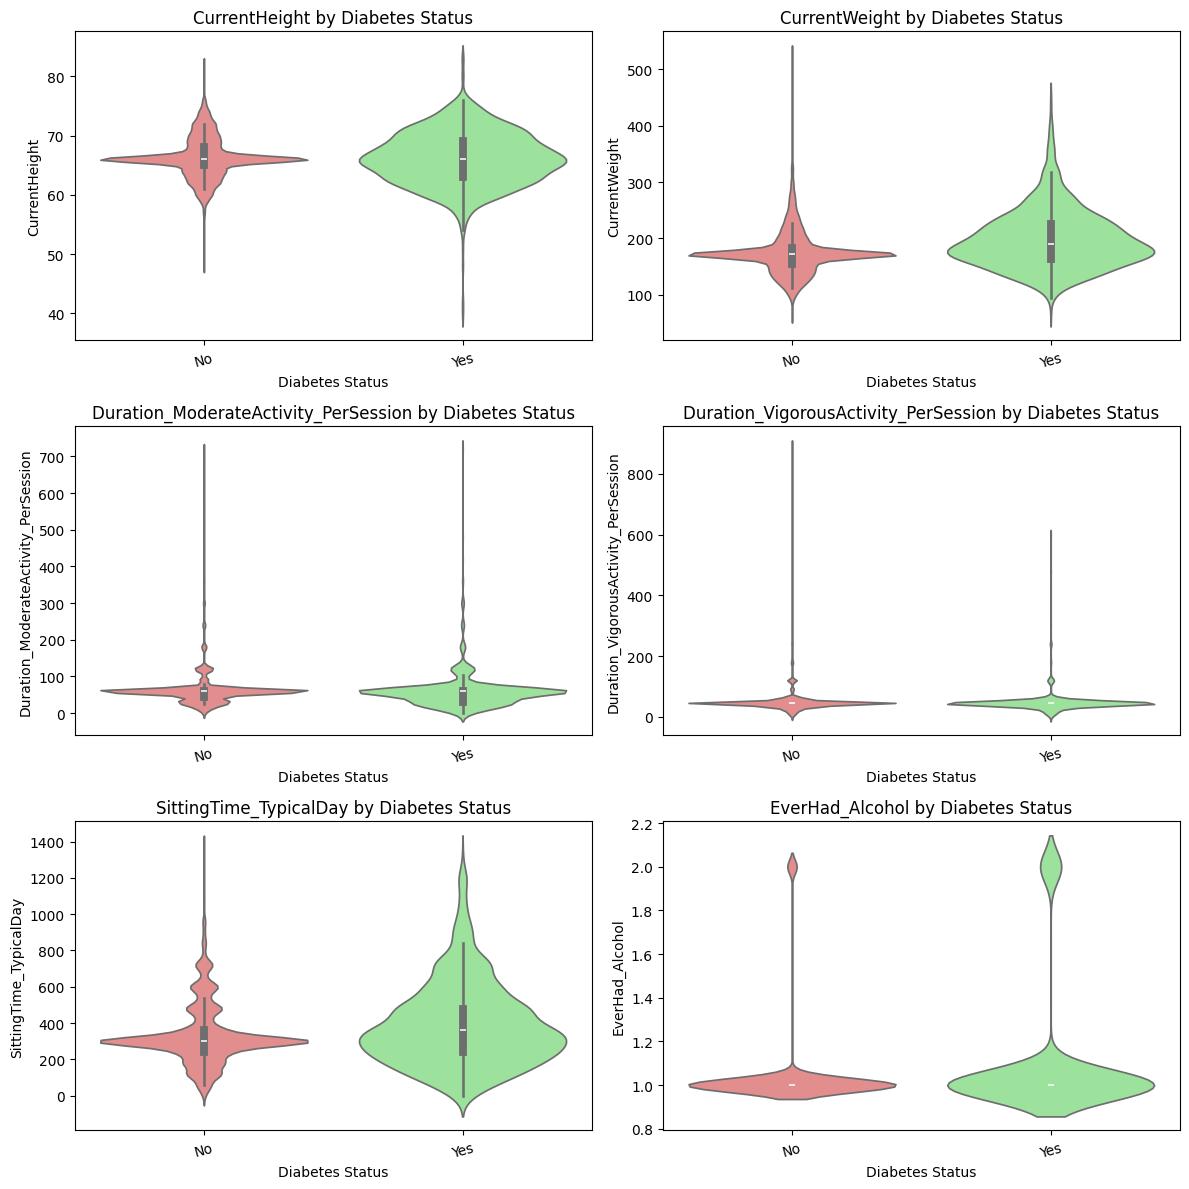

In [205]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping of diabetes status
diabetes_map = {1: "Yes", 2: "No"}

# Prepare data
df_plot = master_df.dropna(subset=['EverTold_Diabetes']).copy()
df_plot['DiabetesStatus'] = df_plot['EverTold_Diabetes'].apply(
    lambda x: diabetes_map.get(int(x), "Missing") if not pd.isna(x) else "Missing"
)

# Keep only numeric columns that exist
existing_cols = [col for col in numeric_cols if col in df_plot.columns]

# Grid size
n_cols = 2
n_rows = math.ceil(len(existing_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Define consistent colors
palette = {
    "Yes": "lightgreen",
    "No": "lightcoral",
    "Missing": "lightgray"
}

for i, col in enumerate(existing_cols):
    sns.violinplot(
        data=df_plot,
        x="DiabetesStatus",
        y=col,
        palette=palette,
        inner='box',
        ax=axes[i]
    )

    axes[i].set_title(f"{col} by Diabetes Status")
    axes[i].set_xlabel("Diabetes Status")
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=15)

# Remove empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Model Training

In [206]:
# Majority class baseline
majority_class = master_df['EverTold_Diabetes'].mode()[0]
baseline_preds = [majority_class] * len(master_df)

# Accuracy
accuracy = (master_df['EverTold_Diabetes'] == baseline_preds).mean()
print(f"Majority class baseline accuracy: {accuracy:.4f}")

# imbalanced dataset, so we will use recall as our metric
# medical context: we want to minimize false negatives (people with diabetes who are not diagnosed) so recall is more important than precision in this case
from sklearn.metrics import recall_score
recall = recall_score(master_df['EverTold_Diabetes'], baseline_preds, pos_label=1)
print(f"Majority class baseline recall: {recall:.4f}")

# 1->yes 2->no 

Majority class baseline accuracy: 0.9056
Majority class baseline recall: 0.0000


In [207]:
# create training data and labels
X = master_df.drop(columns=['EverTold_Diabetes'])
y = master_df['EverTold_Diabetes']

# mapping target variable to binary (1 for diabetes, 0 for no diabetes)
y = y.map({1: 1, 2: 0})
print(y.value_counts())

print(f"Training data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

EverTold_Diabetes
0    10371
1     1081
Name: count, dtype: int64
Training data shape: (11452, 208)
Labels shape: (11452,)


In [208]:
# Train-Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

print(y_train.value_counts())

print(y_test.value_counts())

Training data shape: (9161, 208)
Test data shape: (2291, 208)
EverTold_Diabetes
0    8296
1     865
Name: count, dtype: int64
EverTold_Diabetes
0    2075
1     216
Name: count, dtype: int64


In [209]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    balanced_accuracy_score
)

def evaluate_model(y_test, y_pred, y_prob, model_name="Model"):
    
    print(f"\n================ {model_name} Evaluation ================\n")

    # Classification Report
    print("Classification Report:")
    print(classification_report(
        y_test,
        y_pred,
        labels=[1, 0],
        target_names=['Diabetes (1)', 'No Diabetes (0)']
    ))

    # Metrics for Diabetes (positive class = 1)
    roc_auc = roc_auc_score(y_test, y_prob)
    recall = recall_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    accuracy = (y_test == y_pred).mean()
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Recall (Diabetes): {recall:.4f}")
    print(f"F1-Score (Diabetes): {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # -----------------------------
    # Confusion Matrix
    # -----------------------------
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

    plt.figure()
    plt.imshow(cm)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0, 1], ["Diabetes (1)", "No Diabetes (0)"])
    plt.yticks([0, 1], ["Diabetes (1)", "No Diabetes (0)"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center')

    plt.colorbar()
    plt.show()



    # -----------------------------
    # Threshold vs Metrics
    # -----------------------------
    thresholds = np.linspace(0, 1, 100)
    recalls = []
    f1_scores = []
    accuracies = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        recalls.append(recall_score(y_test, y_pred_thresh, pos_label=1, zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred_thresh, pos_label=1, zero_division=0))
        accuracies.append((y_test == y_pred_thresh).mean())
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    plt.plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(f'{model_name} - Threshold vs Metrics', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

#### Logistic Regression

**Training Approach:**
- Uses L2 regularization with the LBFGS solver for optimization
- Class weights are automatically balanced to handle class imbalance (inverse proportion to class frequencies)
- Maximum iterations set to 5000 to ensure convergence

**Optimization Strategy:**
- `class_weight='balanced'`: Automatically adjusts weights inversely proportional to class frequencies to handle the imbalanced dataset
- `solver='lbfgs'`: Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm, suitable for small to medium datasets
- Predictions use default threshold of 0.5

In [210]:
X_train.select_dtypes(include=['object']).columns


Index([], dtype='object')

Training Logistic Regression model...
Evaluating Logistic Regression model...

================ Logistic Regression Evaluation ================

Classification Report:
                 precision    recall  f1-score   support

   Diabetes (1)       0.32      0.86      0.46       216
No Diabetes (0)       0.98      0.81      0.89      2075

       accuracy                           0.81      2291
      macro avg       0.65      0.83      0.68      2291
   weighted avg       0.92      0.81      0.85      2291

ROC-AUC: 0.9057
Recall (Diabetes): 0.8611
F1-Score (Diabetes): 0.4644
Accuracy: 0.8127
Balanced Accuracy: 0.8344


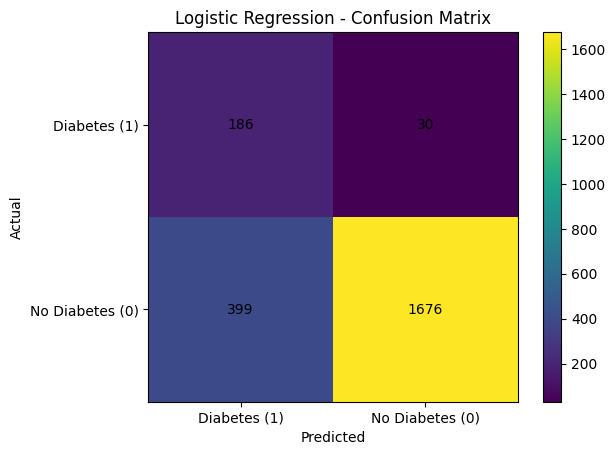

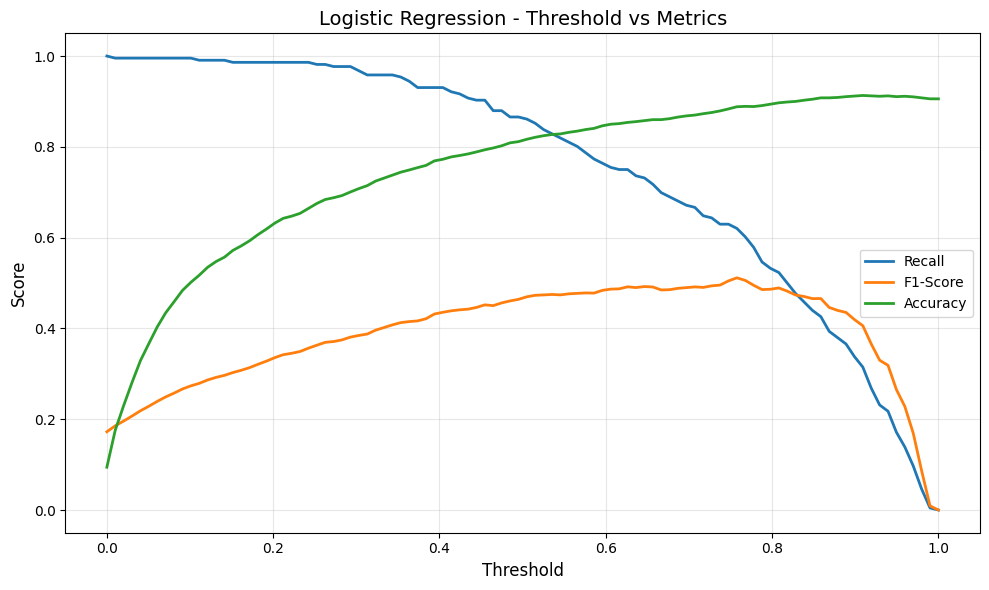

In [211]:
print("Training Logistic Regression model...")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# L2-regularized logistic regression with class balancing to address imbalance
log_reg = LogisticRegression(
    max_iter=5000,            # more iterations to ensure convergence
    random_state=42,
    class_weight='balanced',  # weights inversely proportional to class frequency
    solver='lbfgs'            # efficient solver for L2-regularized logistic regression
)

# Fit model on training data
log_reg.fit(X_train, y_train)

print("Evaluating Logistic Regression model...")
# Predict labels and probabilities for evaluation and threshold-based metrics
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, list(log_reg.classes_).index(1)]

# Evaluate using recall-heavy metrics and curves
evaluate_model(y_test, y_pred, y_prob, model_name="Logistic Regression")


#### Random Forest

**Training Approach:**
- Ensemble learning method using 1000 decision trees
- Uses log2 feature selection at each split for better generalization
- Includes tree depth and leaf size constraints to prevent overfitting

**Optimization Strategy:**
- `class_weight={0:1, 1:3}`: Assigns 3x weight to positive class (diabetes) to prioritize recall over precision
- `max_features='log2'`: Reduces overfitting by using log2(n_features) random features at each split
- `min_samples_split=5` and `min_samples_leaf=2`: Prevents overfitting by controlling minimum samples required for splits and leaf nodes
- **F2-Score Threshold Optimization**: Custom threshold selection based on F2 score (beta=2) which weighs recall 2x more than precision
  - Evaluates precision-recall curve across all possible thresholds
  - Selects threshold that maximizes F2 score to minimize false negatives (critical in medical diagnosis where missing a diabetes case is more costly than a false alarm)

Training Balanced Random Forest...
Selected Threshold (F2 optimized): 0.2252

================ Random Forest (F2 Optimized) Evaluation ================

Classification Report:
                 precision    recall  f1-score   support

   Diabetes (1)       0.29      0.94      0.44       216
No Diabetes (0)       0.99      0.76      0.86      2075

       accuracy                           0.78      2291
      macro avg       0.64      0.85      0.65      2291
   weighted avg       0.93      0.78      0.82      2291

ROC-AUC: 0.9056
Recall (Diabetes): 0.9398
F1-Score (Diabetes): 0.4413
Accuracy: 0.7756
Balanced Accuracy: 0.8492


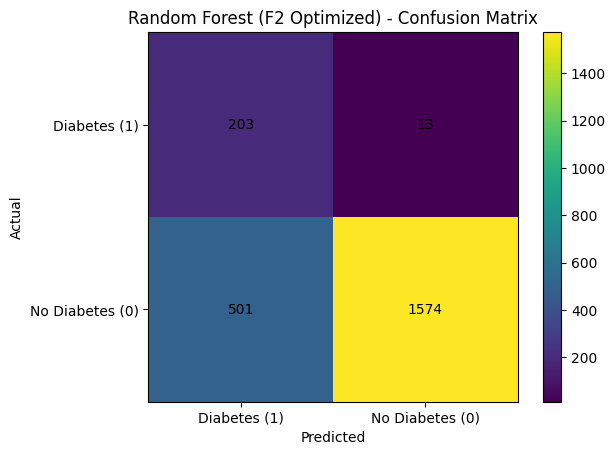

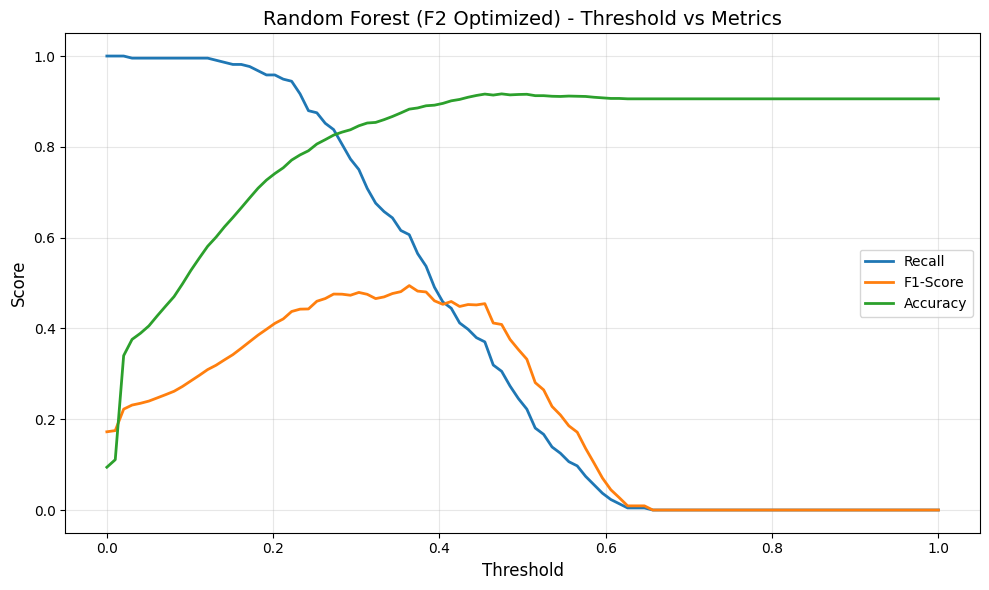

In [212]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

# Balanced Random Forest: class weights emphasize diabetes cases (positive class)
rf_balanced = RandomForestClassifier(
    n_estimators=1000,     # number of trees in the forest
    max_depth=10,        # allow trees to grow fully unless constrained by other params
    min_samples_split=5,   # minimum samples to split an internal node
    min_samples_leaf=2,    # minimum samples at a leaf node (regularization)
    max_features='log2',   # feature subsampling for each split
    class_weight={0:1, 1:3},  # penalize misclassifying positive class more heavily
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

print("Training Balanced Random Forest...")
rf_balanced.fit(X_train, y_train)

# Probability scores for threshold tuning
y_prob_rf = rf_balanced.predict_proba(X_test)[:, 1]

# Precision-recall curve to find best F2 threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_rf)

# F2 score emphasizes recall more than precision (beta=2)
beta = 2
f2_scores = (1 + beta**2) * (precisions[:-1] * recalls[:-1]) / (
    beta**2 * precisions[:-1] + recalls[:-1] + 1e-8
)

best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]

print(f"Selected Threshold (F2 optimized): {best_threshold:.4f}")

# Apply optimized threshold to convert probabilities to class labels
y_pred_rf = (y_prob_rf >= best_threshold).astype(int)

# Evaluate with custom threshold
evaluate_model(
    y_test,
    y_pred_rf,
    y_prob_rf,
    model_name="Random Forest (F2 Optimized)"
)



Top 12 Feature Importances:
EverTold_Hypertension                   0.059644
EverTold_HighCholesterol                0.052705
DifficultyWalkingClimbingSteps_Level    0.044006
GeneralHealth_Status                    0.041465
BMI                                     0.039572
WeightOneYearAgo                        0.033272
CurrentWeight                           0.027638
WorkExperience_LastWeek                 0.025168
Frequency_ModerateActivity              0.016955
OverallHealth_TeethAndGums              0.016608
EverTold_Arthritis                      0.016089
AdultDisabilityIndicator                0.015814
dtype: float64


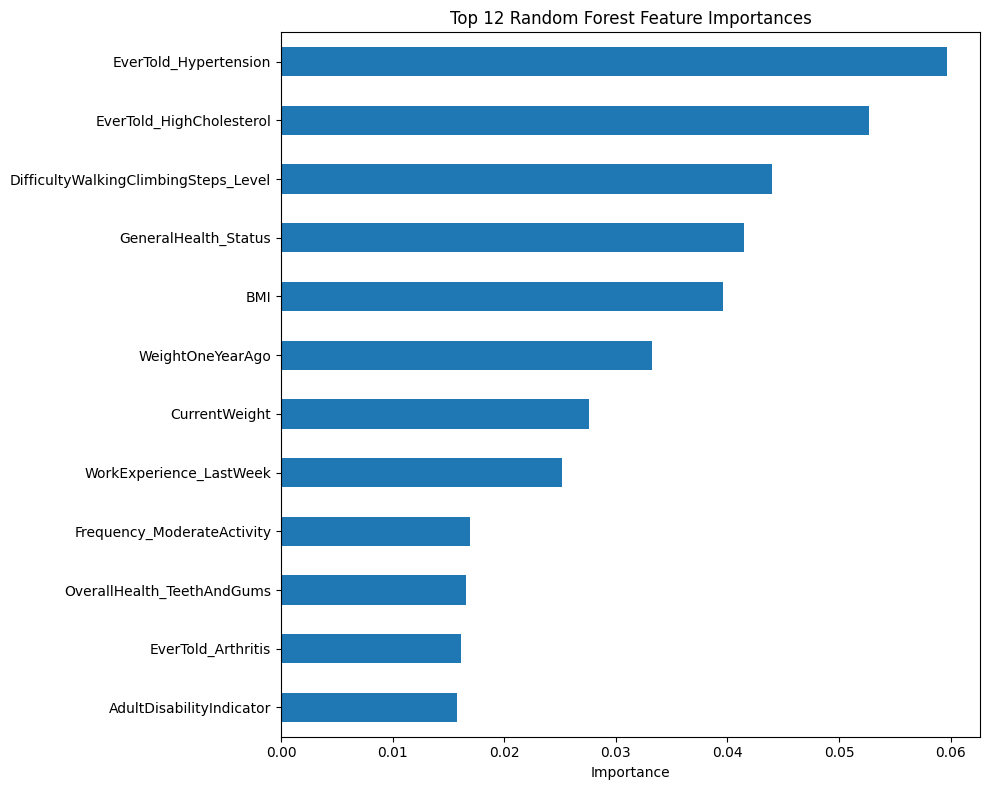

In [213]:
import pandas as pd
import matplotlib.pyplot as plt

rf_model = rf_balanced

feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("\nTop 12 Feature Importances:")
print(feature_importances.head(12))

plt.figure(figsize=(10, 8))
feature_importances.head(12).sort_values().plot(kind='barh')
plt.title("Top 12 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


#### XGBoost

**Training Approach:**
- Gradient boosting algorithm with 800 boosting rounds
- **BorderlineSMOTE**: Synthetic oversampling technique applied to training data to address class imbalance
  - Focuses on borderline samples (near decision boundary) for synthetic generation
  - Creates synthetic minority class samples based on k-nearest neighbors
- Uses sklearn Pipeline to integrate SMOTE with XGBoost

**Optimization Strategy:**
- **Sampling**: BorderlineSMOTE generates synthetic minority class samples to balance training data
- **Hyperparameters**:
  - `max_depth=5`: Controls tree complexity to prevent overfitting
  - `learning_rate=0.03`: Lower learning rate for more careful learning
  - `subsample=0.8`: Uses 80% of samples per tree (stochastic gradient boosting)
  - `colsample_bytree=0.8`: Uses 80% of features per tree for regularization
  - `scale_pos_weight=3`: Additional weight for positive class despite SMOTE
- **F2-Score Threshold Optimization**: Similar to Random Forest, selects optimal threshold based on F2 score
  - Maximizes recall while maintaining reasonable precision
  - Critical for medical applications where false negatives are costly

Training Recall-Optimized XGBoost...
Selected Threshold (F2 optimized): 0.1682

================ XGBoost - BorderlineSMOTE + F2 Threshold Evaluation ================

Classification Report:
                 precision    recall  f1-score   support

   Diabetes (1)       0.33      0.83      0.47       216
No Diabetes (0)       0.98      0.82      0.89      2075

       accuracy                           0.82      2291
      macro avg       0.65      0.83      0.68      2291
   weighted avg       0.92      0.82      0.85      2291

ROC-AUC: 0.9028
Recall (Diabetes): 0.8287
F1-Score (Diabetes): 0.4711
Accuracy: 0.8245
Balanced Accuracy: 0.8264


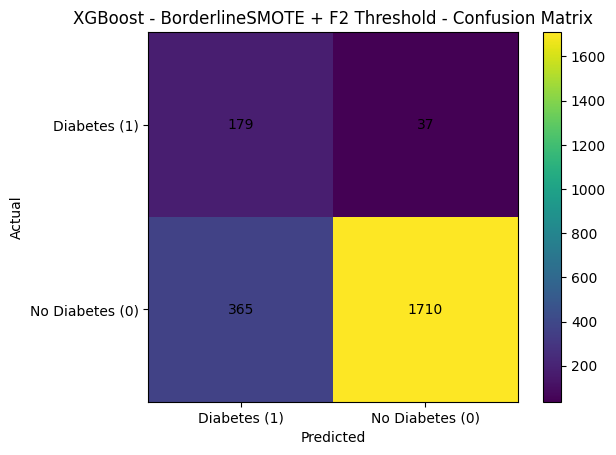

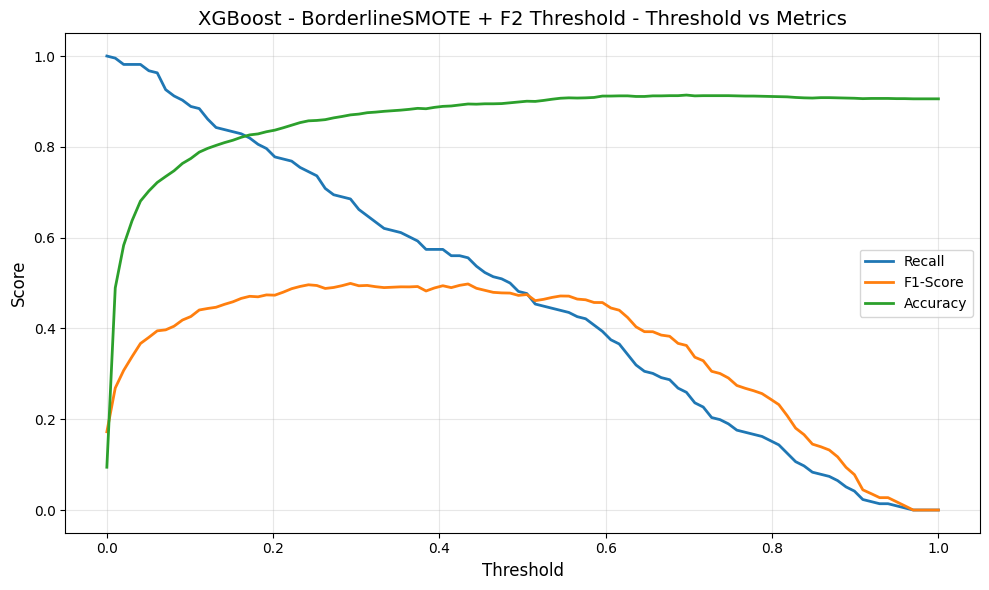

In [214]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE


# Pipeline ensures SMOTE happens only on training data before model fitting
xgb_pipeline = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42)),  # focuses on borderline minority samples
    ('xgb', XGBClassifier(
        n_estimators=800,        # number of boosting rounds
        max_depth=5,             # tree depth (bias/variance tradeoff)
        learning_rate=0.03,      # step size shrinkage for stable learning
        subsample=0.8,           # row sampling for regularization
        colsample_bytree=0.8,    # feature sampling per tree
        scale_pos_weight=3,      # extra weight for positive class
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

print("Training Recall-Optimized XGBoost...")
xgb_pipeline.fit(X_train, y_train)

# Probabilities are used to tune the decision threshold for recall-heavy performance
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Precision-recall curve for threshold selection
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# F2 score emphasizes recall more than precision (beta=2)
beta = 2
f2_scores = (1 + beta**2) * (precisions[:-1] * recalls[:-1]) / (
    beta**2 * precisions[:-1] + recalls[:-1] + 1e-8
)

best_idx = np.argmax(f2_scores)
best_threshold_xgb = thresholds[best_idx]

print(f"Selected Threshold (F2 optimized): {best_threshold_xgb:.4f}")

# Apply optimized threshold to convert probabilities to class labels
y_pred_xgb = (y_prob_xgb >= best_threshold_xgb).astype(int)

evaluate_model(
    y_test,
    y_pred_xgb,
    y_prob_xgb,
    model_name="XGBoost - BorderlineSMOTE + F2 Threshold"
)



Top 10 Feature Importances (XGBoost):
EverTold_Hypertension                      0.240119
EverTold_HighCholesterol                   0.107769
DifficultyWalkingClimbingSteps_Level       0.044541
CurrentlyTaking_BloodPressureMedication    0.037633
GeneralHealth_Status                       0.019581
WorkExperience_LastWeek                    0.018610
MoreThan5000_InSavings                     0.017169
DifficultyUsingHandsFingers_Level          0.015686
AdultEnhancedDisabilityIndicator           0.015585
TelehealthAppointment_Past12Months         0.012974
dtype: float32


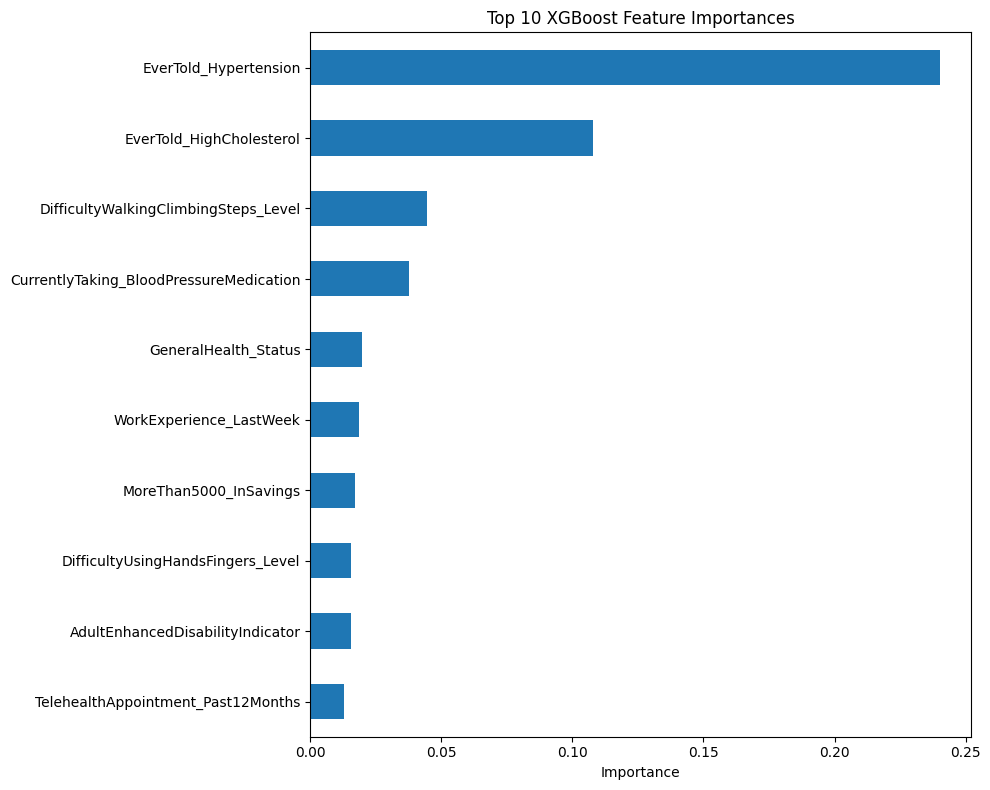

In [215]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract XGBoost model from pipeline
xgb_model = xgb_pipeline.named_steps['xgb']

# Get feature importances
feature_importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("\nTop 10 Feature Importances (XGBoost):")
print(feature_importances.head(10))

plt.figure(figsize=(10, 8))
feature_importances.head(10).sort_values().plot(kind='barh')
plt.title("Top 10 XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#### SVM (Support Vector Machine)

**Training Approach:**
- Linear kernel SVM for binary classification
- Features are standardized using StandardScaler before training
- Probability estimates enabled for ROC-AUC calculation

**Optimization Strategy:**
- **Preprocessing**: StandardScaler normalizes features to zero mean and unit variance (critical for SVM performance)
- `kernel='linear'`: Linear decision boundary, computationally efficient for high-dimensional data
- `C=1.0`: Regularization parameter controlling trade-off between margin maximization and classification error
- `class_weight={0:1, 1:3}`: Assigns 3x penalty for misclassifying positive class (diabetes cases)
- `probability=True`: Enables Platt scaling to produce probability estimates from SVM decision function
- Uses sklearn Pipeline to ensure proper preprocessing order (scaling before SVM)

Training Linear SVM...

================ Linear SVM Evaluation ================

Classification Report:
                 precision    recall  f1-score   support

   Diabetes (1)       0.42      0.59      0.49       216
No Diabetes (0)       0.96      0.92      0.94      2075

       accuracy                           0.89      2291
      macro avg       0.69      0.75      0.71      2291
   weighted avg       0.91      0.89      0.89      2291

ROC-AUC: 0.8941
Recall (Diabetes): 0.5880
F1-Score (Diabetes): 0.4922
Accuracy: 0.8856
Balanced Accuracy: 0.7523


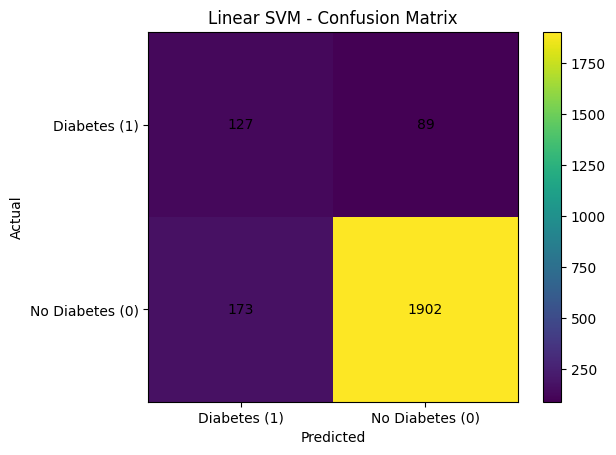

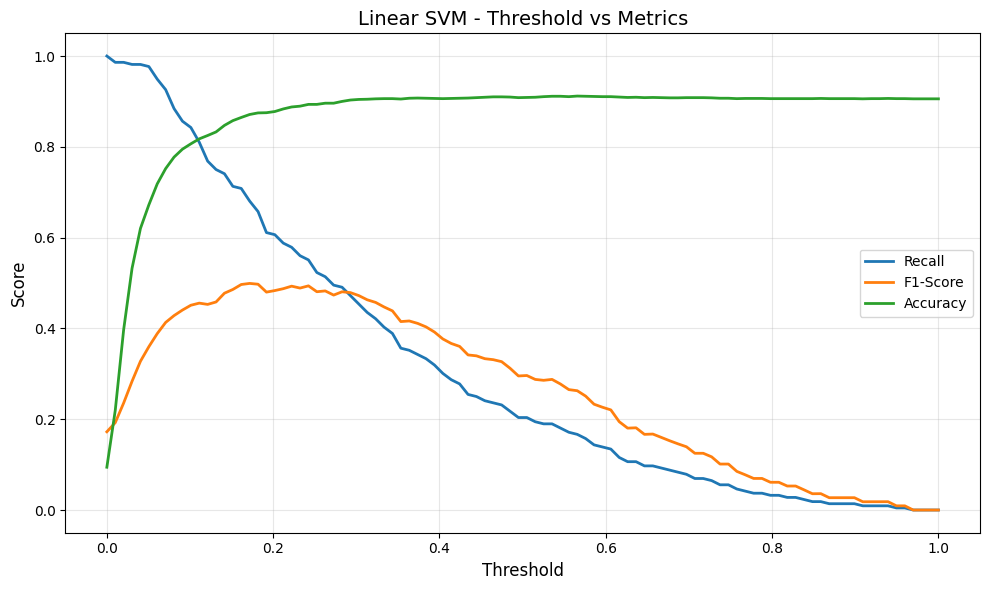

In [216]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

print("Training Linear SVM...")

# Pipeline ensures scaling happens before SVM training
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # normalize features for SVM sensitivity to scale
    ("svm", SVC(
        kernel="linear",          # linear decision boundary for interpretability/speed
        C=1.0,                    # regularization strength (higher = less regularization)
        class_weight={0:1, 1:3},  # emphasize positive class to reduce false negatives
        probability=True,         # enable probability estimates for ROC/AUC
        random_state=42
    ))
])

# Train on scaled features
svm_pipeline.fit(X_train, y_train)

# Predict labels and probabilities for evaluation
y_pred_svm = svm_pipeline.predict(X_test)
y_prob_svm = svm_pipeline.predict_proba(X_test)[:, 1]

# Evaluate model performance
evaluate_model(
    y_test,
    y_pred_svm,
    y_prob_svm,
    model_name="Linear SVM"
)
